In [2]:
import numpy as np
import pandas as pd

from tqdm.notebook import tqdm
import pickle
import gc

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import catboost as cb
import xgboost as xgb
import lightgbm as lgb
from sklearn.linear_model import LinearRegression
# from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVR
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# Train/test split

For a sake of the programming assignment, let's artificially split the data into train and test. We will treat last month data as the test set.

In [3]:
# Will we save intermediate models?
save_models = True

In [4]:
all_data = pd.read_parquet('data/all_data.parquet')
# print('Columns:', all_data.columns)
all_data.info()
all_data

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6639294 entries, 0 to 6639293
Data columns (total 84 columns):
 #   Column                                 Dtype  
---  ------                                 -----  
 0   shop_id                                int32  
 1   item_id                                int32  
 2   date_block_num                         int32  
 3   item_category_id                       int32  
 4   target                                 float32
 5   target_shop_date                       float32
 6   target_item_date                       float32
 7   target_item_shop_date                  float32
 8   target_item-cat_date                   float32
 9   target_shop_item-cat_date              float32
 10  target_mean                            float32
 11  target_shop_date_mean                  float32
 12  target_item_date_mean                  float32
 13  target_item_shop_date_mean             float32
 14  target_item-cat_date_mean              float32
 15

,shop_id,item_id,date_block_num,item_category_id,target,target_shop_date,target_item_date,target_item_shop_date,target_item-cat_date,target_shop_item-cat_date,...,target_shop_item-cat_date_lag_12,target_shop_item-cat_date_mean_lag_12,city_code,type_code,subtype_code,month_num,item_first_sale,item_shop_first_sale,days,delta_price_lag
0,59,944,12,37,1.0,1491.0,23.0,1.0,7511.0,104.0,...,60.0,60.0,30,11,1,0,0,0,31,0.000000
1,59,21861,12,37,1.0,1491.0,62.0,1.0,7511.0,104.0,...,60.0,60.0,30,11,1,0,0,0,31,0.000000
2,59,21455,12,37,1.0,1491.0,20.0,1.0,7511.0,104.0,...,60.0,60.0,30,11,1,0,0,0,31,0.000000
3,59,33,12,37,2.0,1491.0,42.0,2.0,7511.0,104.0,...,60.0,60.0,30,11,1,0,0,0,31,0.000000
4,59,19750,12,37,1.0,1491.0,8.0,1.0,7511.0,104.0,...,60.0,60.0,30,11,1,0,0,0,31,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6639289,45,18454,34,55,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,20,13,2,10,11,11,30,-0.475305
6639290,45,16188,34,64,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,20,14,42,10,2,2,30,0.081167
6639291,45,15757,34,55,0.0,0.0,0.0,0.0,0.0,0.0,...,124.0,124.0,20,13,2,10,22,22,30,0.155905
6639292,45,19648,34,40,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,20,11,4,10,11,11,30,-0.091709


In [5]:
# list(all_data.columns)

In [6]:
# List of all lagged features

# We will drop these at fitting stage
to_drop_cols = ['target_shop_date', 'target_item_shop_date_mean', 'target_shop_item-cat_date_mean', 'target_shop_item-cat_date', 
                'target_item_date_mean', 'target_item-cat_date_mean', 'target_item-cat_date', 'target_item_shop_date', 
                'target_item_date', 'target', 'target_shop_date_mean', 'target_mean', 'date_block_num']

# Categorical features
cat_features = ['shop_id', 'item_id', 'item_category_id', 'city_code', 
                'type_code', 'subtype_code']

In [7]:
# Save `date_block_num`, as we can't use them as features, but will need them to split the dataset into parts 
dates = all_data['date_block_num']

last_block = dates.max()-1
print('Test `date_block_num` is %d' % last_block)

Test `date_block_num` is 33


In [8]:
dates_train = dates[dates <  last_block]
dates_test  = dates[dates == last_block]

X_train =  all_data.loc[dates <  last_block].drop(to_drop_cols, axis=1)
X_test =   all_data.loc[dates == last_block].drop(to_drop_cols, axis=1)
X_target = all_data.loc[dates == dates.max()].drop(to_drop_cols, axis=1)

y_train = all_data.loc[dates <  last_block, 'target'].values
y_test =  all_data.loc[dates == last_block, 'target'].values

In [9]:
X_train

,shop_id,item_id,item_category_id,target_lag_1,target_item-cat_date_lag_1,target_item-cat_date_mean_lag_1,target_item_date_lag_1,target_item_date_mean_lag_1,target_item_shop_date_lag_1,target_item_shop_date_mean_lag_1,...,target_shop_item-cat_date_lag_12,target_shop_item-cat_date_mean_lag_12,city_code,type_code,subtype_code,month_num,item_first_sale,item_shop_first_sale,days,delta_price_lag
0,59,944,37,0.0,9959.0,9959.0,24.0,24.0,0.0,0.0,...,60.0,60.0,30,11,1,0,0,0,31,0.000000
1,59,21861,37,0.0,9959.0,9959.0,28.0,28.0,0.0,0.0,...,60.0,60.0,30,11,1,0,0,0,31,0.000000
2,59,21455,37,1.0,9959.0,9959.0,12.0,12.0,1.0,1.0,...,60.0,60.0,30,11,1,0,0,0,31,0.000000
3,59,33,37,0.0,9959.0,9959.0,42.0,42.0,0.0,0.0,...,60.0,60.0,30,11,1,0,0,0,31,0.000000
4,59,19750,37,0.0,9959.0,9959.0,15.0,15.0,0.0,0.0,...,60.0,60.0,30,11,1,0,0,0,31,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6186917,55,5230,26,1.0,6.0,6.0,1.0,1.0,1.0,1.0,...,0.0,0.0,27,6,61,7,8,8,31,0.058935
6186918,55,2757,26,4.0,6.0,6.0,4.0,4.0,4.0,4.0,...,0.0,0.0,27,6,61,7,8,8,31,-0.031505
6186919,55,7115,27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,27,7,61,7,0,0,31,0.000000
6186920,55,13095,36,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,27,9,15,7,0,0,31,0.000000


In [10]:
del all_data
gc.collect()

127

# First level models 

You need to implement a basic stacking scheme. We have a time component here, so we will use ***scheme f)*** from the reading material. Recall, that we always use first level models to build two datasets: test meta-features and 2-nd level train-metafetures. Let's see how we get test meta-features first. 

### Test meta-features

Firts, we will run *linear regression* on numeric columns and get predictions for the last month.

In [17]:
%%time
model_lr = make_pipeline(
    StandardScaler(), 
    LinearRegression()
)
model_lr.fit(X_train.values, y_train)
pred_lr = model_lr.predict(X_test.values)

print('Test R-squared for linreg is %f' % r2_score(y_test, pred_lr))
print('Test RMSE linreg is %f' % np.sqrt(mean_squared_error(y_test, pred_lr)))

if save_models:
    pickle.dump(model_lr, open('data/sa-model_lr.pkl', "wb"))

Test R-squared for linreg is 0.279051
Test RMSE linreg is 0.964695


And the we run *LightGBM*.

Training until validation scores don't improve for 100 rounds
[100]	valid_0's l2: 0.856151
[200]	valid_0's l2: 0.865528
Early stopping, best iteration is:
[122]	valid_0's l2: 0.853702

Test R-squared for LightGBM is 0.338650
Test RMSE LightGBM is 0.923960

CPU times: user 5min 32s, sys: 4.63 s, total: 5min 37s
Wall time: 1min 39s


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

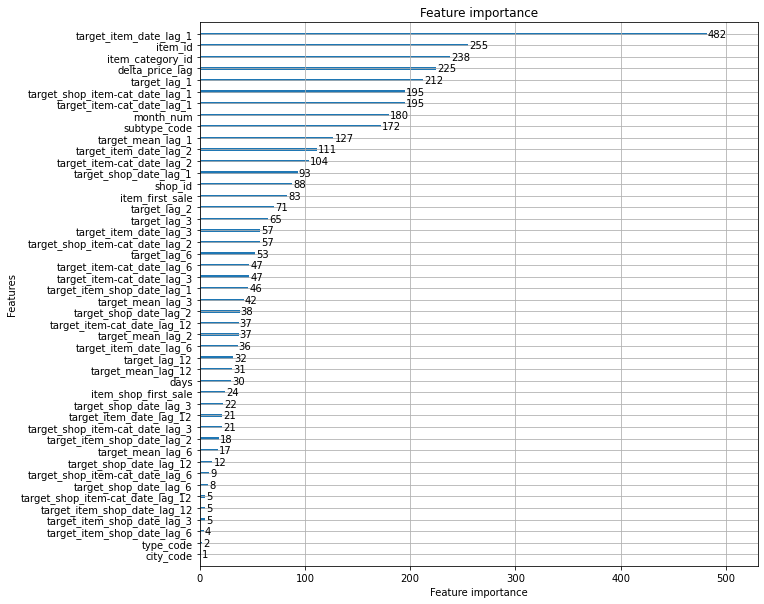

In [12]:
%%time
# LightGBM
model_lgb = lgb.LGBMRegressor(
    n_estimators=1000,
    n_jobs=-1,
    objective='mse',
    random_state=17
)

model_lgb.fit(
    X_train, y_train, 
    eval_set=(X_test, y_test), 
    early_stopping_rounds=100,
    verbose=100
)
pred_lgb = model_lgb.predict(X_test)

print('\nTest R-squared for LightGBM is %f' % r2_score(y_test, pred_lgb))
print('Test RMSE LightGBM is %f' % np.sqrt(mean_squared_error(y_test, pred_lgb)))
print()

# Save model to disk
if save_models:
    pickle.dump(model_lgb, open('data/sa-model_lgb.pkl', "wb"))

# Plot LightGBM features importance
fig, ax = plt.subplots(1,1,figsize=(10, 10))
lgb.plot_importance(booster=model_lgb, ax=ax)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.239925
0:	learn: 1.0943423	test: 1.0733201	best: 1.0733201 (0)	total: 1.13s	remaining: 18m 46s
20:	learn: 0.8827077	test: 0.9454934	best: 0.9454934 (20)	total: 24.8s	remaining: 19m 15s
40:	learn: 0.8600629	test: 0.9351685	best: 0.9345706 (37)	total: 52s	remaining: 20m 16s
60:	learn: 0.8502605	test: 0.9330742	best: 0.9326933 (59)	total: 1m 17s	remaining: 19m 50s
80:	learn: 0.8403724	test: 0.9298684	best: 0.9298684 (80)	total: 1m 42s	remaining: 19m 21s
100:	learn: 0.8340127	test: 0.9291086	best: 0.9291086 (100)	total: 2m 7s	remaining: 18m 55s
120:	learn: 0.8260572	test: 0.9245310	best: 0.9245310 (120)	total: 2m 33s	remaining: 18m 37s
140:	learn: 0.8212039	test: 0.9237221	best: 0.9237221 (140)	total: 2m 58s	remaining: 18m 5s
160:	learn: 0.8168601	test: 0.9212810	best: 0.9212810 (160)	total: 3m 22s	remaining: 17m 34s
180:	learn: 0.8127396	test: 0.9217372	best: 0.9195250 (173)	total: 3m 47s	remaining: 17m 8s
200:	learn: 0.8102903	test: 0.9205581	best: 0.9195250 (173)	

<AxesSubplot:title={'center':'Feature importances'}, ylabel='Feature Id'>

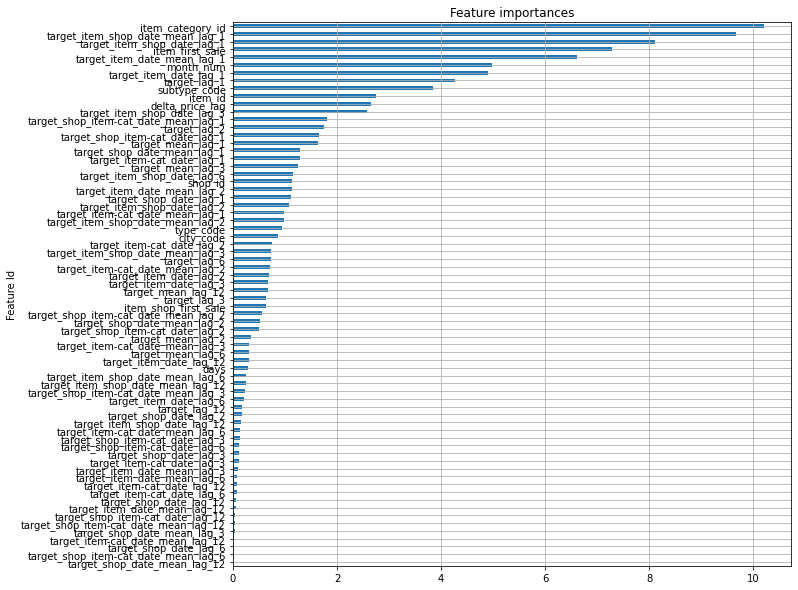

In [14]:
%%time
# Catboost

model_cbr = cb.CatBoostRegressor(
    loss_function='RMSE',
    #cat_features=cat_features,
    iterations=1000,
    task_type='CPU',
)
model_cbr.fit(
    X_train, y_train, 
    eval_set=(X_test, y_test), 
    verbose=20, 
    early_stopping_rounds=20,
    plot=True,
)
pred_cb = model_cbr.predict(X_test)

print('\nTest R-squared for CatBoost is %f' % r2_score(y_test, pred_cb))
print('Test RMSE CatBoost is %f' % np.sqrt(mean_squared_error(y_test, pred_cb)))
print()

# Save model to disk
if save_models:
    pickle.dump(model_cbr, open('data/sa-model_cbr.pkl', "wb"))

# Plot CatBoost features importance
f_importance = model_cbr.get_feature_importance(prettified=True)
f_importance[f_importance['Importances']>0].sort_values(by='Importances', ascending=True).set_index('Feature Id').plot(
    kind='barh', figsize=(10,10), legend=False, grid=True, title="Feature importances");

In [90]:
model_cbr.get_all_params()

{'nan_mode': 'Min',
 'eval_metric': 'RMSE',
 'iterations': 1000,
 'sampling_frequency': 'PerTree',
 'leaf_estimation_method': 'Newton',
 'od_pval': 0,
 'grow_policy': 'SymmetricTree',
 'penalties_coefficient': 1,
 'boosting_type': 'Plain',
 'model_shrink_mode': 'Constant',
 'feature_border_type': 'GreedyLogSum',
 'bayesian_matrix_reg': 0.10000000149011612,
 'l2_leaf_reg': 3,
 'random_strength': 1,
 'od_type': 'Iter',
 'rsm': 1,
 'boost_from_average': True,
 'model_size_reg': 0.5,
 'subsample': 0.800000011920929,
 'use_best_model': True,
 'od_wait': 50,
 'random_seed': 0,
 'depth': 6,
 'border_count': 254,
 'classes_count': 0,
 'auto_class_weights': 'None',
 'sparse_features_conflict_fraction': 0,
 'leaf_estimation_backtracking': 'AnyImprovement',
 'best_model_min_trees': 1,
 'model_shrink_rate': 0,
 'min_data_in_leaf': 1,
 'loss_function': 'RMSE',
 'learning_rate': 0.2399249970912933,
 'score_function': 'Cosine',
 'task_type': 'CPU',
 'leaf_estimation_iterations': 1,
 'bootstrap_type':

[18:58:04] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1598185621802/work/src/gbm/gbtree.cc:139: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[0]	validation_0-rmse:1.05590	validation_1-rmse:1.05120
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[10]	validation_0-rmse:0.84260	validation_1-rmse:0.92286
[20]	validation_0-rmse:0.82351	validation_1-rmse:0.91870
[30]	validation_0-rmse:0.81376	validation_1-rmse:0.91742
[40]	validation_0-rmse:0.80537	validation_1-rmse:0.91529
[50]	validation_0-rmse:0.80138	validation_1-rmse:0.91410
[60]	validation_0-rmse:0.79685	validation_1-rmse:0.90962
[70]	validation_0-rmse:0.79257	validation_1-rmse:0.90807
[80]	validation_0-rmse:0.78496	validation_1-rmse:0.91424
[90]	validation_0-rmse:0.78251	validation_1-rmse:0.91

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

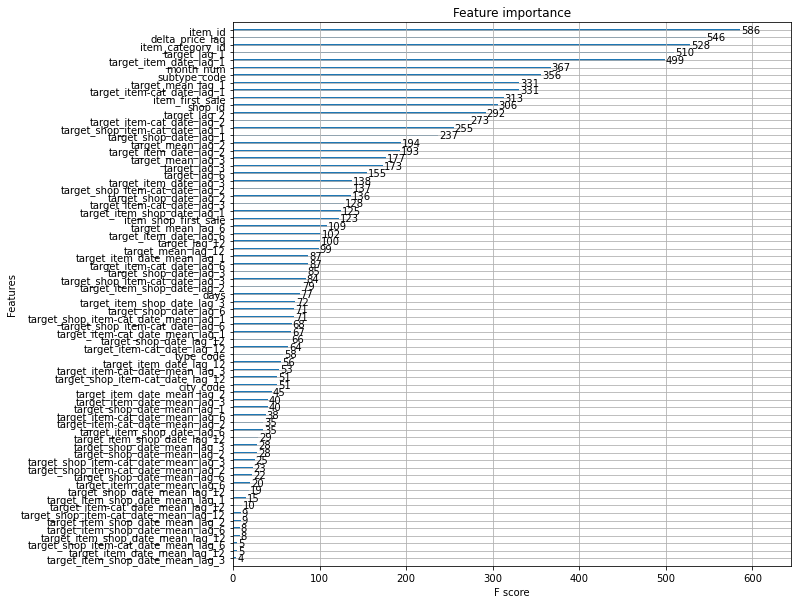

In [62]:
%%time
# xgboost
model_xgb = xgb.XGBRegressor(
    n_jobs=4, 
    random_state=17,
    max_depth=8,
    n_estimators=1000,
    min_child_weight=300, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.3,
)

model_xgb.fit(
    X_train, y_train, 
    eval_set=[(X_train, y_train), (X_test, y_test)], 
    eval_metric="rmse", 
    verbose=5, 
    early_stopping_rounds = 20
)
pred_xgb = model_xgb.predict(X_test)

print('\nTest R-squared for XGBoost is %f' % r2_score(y_test, pred_xgb))
print('Test RMSE XGBoost is %f' % np.sqrt(mean_squared_error(y_test, pred_xgb)))
print()

# Save model to disk
if save_models:
    pickle.dump(model_xgb, open('data/sa-model_xgb.pkl', "wb"))

# Plot XGBoost features importance
fig, ax = plt.subplots(1,1,figsize=(10, 10))
xgb.plot_importance(booster=model_xgb, ax=ax)

In [74]:
%%time
# BayesianRidge regression
from sklearn.linear_model import BayesianRidge

model_br = make_pipeline(
    StandardScaler(), 
    BayesianRidge() #n_iter=1000, tol=0.0001)
)

model_br.fit(X_train.values, y_train)
pred_br = model_br.predict(X_test.values)

print('Test BayesianRidge linreg is %f' % np.sqrt(mean_squared_error(y_test, pred_br)))

if save_models:
    pickle.dump(model_br, open('data/sa-model_br.pkl', "wb"))

Test BayesianRidge linreg is 0.964708
CPU times: user 3min 10s, sys: 26.1 s, total: 3min 36s
Wall time: 1min 34s


In [72]:
%%time
# ElasticNetCV
from sklearn.linear_model import ElasticNetCV

model_en = make_pipeline(
    StandardScaler(), 
    ElasticNetCV(n_jobs=4, random_state=17, max_iter=1000)
)
model_en.fit(X_train.values, y_train)
pred_en = model_en.predict(X_test.values)

print('Test ElasticNet linreg is %f' % np.sqrt(mean_squared_error(y_test, pred_en)))

if save_models:
    pickle.dump(model_en, open('data/sa-model_en.pkl', "wb"))

Test ElasticNet linreg is 0.965580
CPU times: user 9min 40s, sys: 1min 35s, total: 11min 16s
Wall time: 4min 53s


In [63]:
%%time
# LassoCV
from sklearn.linear_model import LassoCV

model_lcv =  make_pipeline(
    StandardScaler(),
    LassoCV(n_jobs=4, random_state=17)
)
model_lcv.fit(X_train.values, y_train)
pred_lcv = model_lcv.predict(X_test.values)

print('Test LassoCV is %f' % np.sqrt(mean_squared_error(y_test, pred_lcv)))

if save_models:
    pickle.dump(model_lcv, open('data/sa-model_lcv.pkl', "wb"))

Test LassoCV is 0.965963
CPU times: user 2min 53s, sys: 59.1 s, total: 3min 52s
Wall time: 3min 8s


In [70]:
%%time
# RidgeCV
from sklearn.linear_model import RidgeCV

model_rcv =  make_pipeline(
    StandardScaler(),
    RidgeCV(scoring='neg_mean_squared_error')
)
model_rcv.fit(X_train.values, y_train)
pred_rcv = model_rcv.predict(X_test.values)

print('Test RidgeCV is %f' % np.sqrt(mean_squared_error(y_test, pred_rcv)))

if save_models:
    pickle.dump(model_rcv, open('data/sa-model_rcv.pkl', "wb"))

Test RidgeCV is 0.964709
CPU times: user 3min 16s, sys: 37.1 s, total: 3min 53s
Wall time: 2min 12s


In [35]:
%%time
from sklearn.linear_model import SGDRegressor

model_sgdr = make_pipeline(
    StandardScaler(), 
    SGDRegressor(shuffle=False, verbose=0, 
                early_stopping=False, learning_rate='adaptive', 
                eta0=0.001, loss='epsilon_insensitive',
                penalty="elasticnet")
)

model_sgdr.fit(X_train.values, y_train)
pred_sgdr = model_sgdr.predict(X_test.values)

print('Test SGDRegressor is %f' % np.sqrt(mean_squared_error(y_test, pred_sgdr)))

if save_models:
    pickle.dump(model_sgdr, open('data/sa-model_sgdr.pkl', "wb"))

-- Epoch 1
Norm: 7.61, NNZs: 44, Bias: 0.254000, T: 6186922, Avg. loss: 0.219797
Total training time: 2.58 seconds.
-- Epoch 2
Norm: 9.92, NNZs: 38, Bias: 0.258000, T: 12373844, Avg. loss: 0.219146
Total training time: 5.18 seconds.
-- Epoch 3
Norm: 10.84, NNZs: 38, Bias: 0.236000, T: 18560766, Avg. loss: 0.219353
Total training time: 7.78 seconds.
-- Epoch 4
Norm: 11.34, NNZs: 37, Bias: 0.220000, T: 24747688, Avg. loss: 0.219156
Total training time: 10.38 seconds.
-- Epoch 5
Norm: 11.54, NNZs: 35, Bias: 0.224000, T: 30934610, Avg. loss: 0.219159
Total training time: 12.98 seconds.
-- Epoch 6
Norm: 11.64, NNZs: 37, Bias: 0.220000, T: 37121532, Avg. loss: 0.219152
Total training time: 15.59 seconds.
-- Epoch 7
Norm: 10.73, NNZs: 27, Bias: 0.170600, T: 43308454, Avg. loss: 0.224889
Total training time: 18.18 seconds.
-- Epoch 8
Norm: 9.93, NNZs: 30, Bias: 0.167800, T: 49495376, Avg. loss: 0.224798
Total training time: 20.77 seconds.
-- Epoch 9
Norm: 9.23, NNZs: 30, Bias: 0.165800, T: 556

## Load pickled predictors 

In [36]:
# Load pickled predictors
if save_models:
    model_lr   = pickle.load(open('data/sa-model_lr.pkl', "rb"))    # LinearRegression
    model_lgb  = pickle.load(open('data/sa-model_lgb.pkl', "rb"))   # LightGBM
    model_cbr  = pickle.load(open('data/sa-model_cbr.pkl', "rb"))   # CatBoost
    model_xgb  = pickle.load(open('data/sa-model_xgb.pkl', "rb"))   # xgboost
    model_br   = pickle.load(open('data/sa-model_br.pkl', "rb"))    # BayesianRidge
    model_sgdr = pickle.load(open('data/sa-model_sgdr.pkl', "rb"))  # SGDRegressor

In [75]:
%%time
# Make predictions for test data
train_lr  = model_lr.predict(X_train)
train_lgb = model_lgb.predict(X_train)
train_cbr = model_cbr.predict(X_train)
train_xgb = model_xgb.predict(X_train)
train_br  = model_br.predict(X_train)
train_sgdr= model_sgdr.predict(X_train)

X_train_level2 = np.c_[train_lr, train_lgb, train_cbr, train_xgb, train_br, train_sgdr] 
# X_test_level2.tofile('X_test_level2')
print('Train L2 data shape:', X_train_level2.shape)

Train L2 data shape: (6186922, 6)
CPU times: user 2min 2s, sys: 7.77 s, total: 2min 9s
Wall time: 1min 5s


In [76]:
%%time
# Make predictions for test data (Kaggle's test dataset)
test_lr  = model_lr.predict(X_test)
test_lgb = model_lgb.predict(X_test)
test_cbr = model_cbr.predict(X_test)
test_xgb = model_xgb.predict(X_test)
test_br  = model_br.predict(X_test)
test_sgdr= model_sgdr.predict(X_test)

X_test_level2 = np.c_[test_lr, test_lgb, test_cbr, test_xgb, test_br, test_sgdr]
print('Test L2 data shape:', X_test_level2.shape)

Test L2 data shape: (238172, 6)
CPU times: user 6.35 s, sys: 529 ms, total: 6.88 s
Wall time: 2.33 s


In [77]:
%%time
# Make prediction for target data
target_lr  = model_lr.predict(X_target)
target_lgb = model_lgb.predict(X_target)
target_cbr = model_cbr.predict(X_target)
target_xgb = model_xgb.predict(X_target)
target_br  = model_br.predict(X_target)
target_sgdr= model_sgdr.predict(X_target)

X_target_level2 = np.c_[target_lr, target_lgb, target_cbr, target_xgb, target_br, target_sgdr]
print('Target L2 data shape:', X_target_level2.shape)

Target L2 data shape: (214200, 6)
CPU times: user 6.5 s, sys: 633 ms, total: 7.13 s
Wall time: 4.07 s


## Let's make L2 predictions

In [78]:
%%time
l2_model_lr = LinearRegression()
l2_model_lr.fit(X_train_level2, y_train)
test_l2_lr = l2_model_lr.predict(X_test_level2)

print(f'Test RMSE for LinearRegression L2 is {np.sqrt(mean_squared_error(y_test, test_l2_lr))}')

Test RMSE for LinearRegression L2 is 0.9205406594268989
CPU times: user 1.61 s, sys: 498 ms, total: 2.1 s
Wall time: 1.28 s


In [79]:
from sklearn.linear_model import ElasticNetCV
l2_model_en = ElasticNetCV()
l2_model_en.fit(X_train_level2, y_train)
test_l2_en = l2_model_en.predict(X_test_level2)

print(f'Test RMSE for ElasticNet L2 is {np.sqrt(mean_squared_error(y_test, test_l2_en))}')

Test RMSE for ElasticNet L2 is 0.9195124326824132


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2109.0175161384977, tolerance: 873.5575242300343
  model = cd_fast.enet_coordinate_descent(


In [80]:
%%time
# BayesianRidge regression
from sklearn.linear_model import BayesianRidge
l2_model_br = BayesianRidge()
l2_model_br.fit(X_train_level2, y_train)
test_l2_br = l2_model_br.predict(X_test_level2)

# print('Test R-squared for linreg is %f' % r2_score(y_test, pred_lr))
print('Test BayesianRidge L2 is %f' % np.sqrt(mean_squared_error(y_test, test_l2_br)))

Test BayesianRidge linreg is 0.920550
CPU times: user 4.92 s, sys: 1.76 s, total: 6.68 s
Wall time: 2.28 s


In [88]:
%%time
# LassoCV
from sklearn.linear_model import LassoCV

l2_model_lcv = LassoCV(n_jobs=4, random_state=17)

l2_model_lcv.fit(X_train_level2, y_train)
test_l2_lcv = l2_model_lcv.predict(X_test_level2)

print('Test LassoCV L2 is %f' % np.sqrt(mean_squared_error(y_test, test_l2_lcv)))

Test LassoCV L2 is 0.919829
CPU times: user 3min 6s, sys: 20.1 s, total: 3min 27s
Wall time: 1min 4s


In [81]:
%%time
from sklearn.linear_model import SGDRegressor

l2_model_sgdr = make_pipeline(
    StandardScaler(), 
    SGDRegressor(shuffle=False, verbose=0, early_stopping=False, learning_rate='adaptive', 
                 eta0=0.0001, loss='epsilon_insensitive',
                 penalty="elasticnet")
)
l2_model_sgdr.fit(X_train.values, y_train)
test_l2_sgdr = l2_model_sgdr.predict(X_test.values)

print(f'Test RMSE for SVR L2 is {np.sqrt(mean_squared_error(y_test, test_l2_sgdr))}')

Test RMSE for SVR L2 is 0.9908889885503084
CPU times: user 1min 3s, sys: 1.89 s, total: 1min 5s
Wall time: 1min 5s


In [82]:
%%time
l2_model_cb = cb.CatBoostRegressor(
    loss_function='RMSE',
    task_type='CPU',
    #depth=8,
    #learning_rate=0.001,
    #l2_leaf_reg=6,
)
l2_model_cb.fit(X_train_level2, y=y_train,
                eval_set=(X_test_level2, y_test),
                early_stopping_rounds=20,
                verbose=20,
                use_best_model=True,
                plot=True)
test_l2_cbr = l2_model_cb.predict(X_test_level2)

print(f'Test RMSE for CatBoost L2 is {np.sqrt(mean_squared_error(y_test, test_l2_cbr))}')

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.239925
0:	learn: 1.0510686	test: 1.0374542	best: 1.0374542 (0)	total: 3.95s	remaining: 1h 5m 49s
20:	learn: 0.8039778	test: 0.9477065	best: 0.9265142 (6)	total: 13.6s	remaining: 10m 35s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.9265141823
bestIteration = 6

Shrink model to first 7 iterations.
Test RMSE for CatBoost L2 is 0.92651418227436
CPU times: user 51.8 s, sys: 4.3 s, total: 56.1 s
Wall time: 43.3 s


In [57]:
print(f'Test RMSE for CatBoost L2 is {np.sqrt(mean_squared_error(y_test, test_l2_cbr))}')

Test RMSE for CatBoost L2 is 0.92651418227436


In [53]:
# l2_model_cb.get_all_params()

{'nan_mode': 'Min',
 'eval_metric': 'RMSE',
 'iterations': 1000,
 'sampling_frequency': 'PerTree',
 'leaf_estimation_method': 'Newton',
 'od_pval': 0,
 'grow_policy': 'SymmetricTree',
 'penalties_coefficient': 1,
 'boosting_type': 'Plain',
 'model_shrink_mode': 'Constant',
 'feature_border_type': 'GreedyLogSum',
 'bayesian_matrix_reg': 0.10000000149011612,
 'l2_leaf_reg': 3,
 'random_strength': 1,
 'od_type': 'Iter',
 'rsm': 1,
 'boost_from_average': True,
 'model_size_reg': 0.5,
 'subsample': 0.800000011920929,
 'use_best_model': True,
 'od_wait': 20,
 'random_seed': 0,
 'depth': 8,
 'border_count': 254,
 'classes_count': 0,
 'auto_class_weights': 'None',
 'sparse_features_conflict_fraction': 0,
 'leaf_estimation_backtracking': 'AnyImprovement',
 'best_model_min_trees': 1,
 'model_shrink_rate': 0,
 'min_data_in_leaf': 1,
 'loss_function': 'RMSE',
 'learning_rate': 0.2399249970912933,
 'score_function': 'Cosine',
 'task_type': 'CPU',
 'leaf_estimation_iterations': 1,
 'bootstrap_type':

## Prepare data to Kaggle

In [91]:
# Make submission

# Insert your model here
pred_model = l2_model_en # ElasticNetCV

tests = pd.read_csv('../readonly/final_project_data/test.csv.gz')
# export_pred = l2_model_lr.predict(X_target_level2)

export_pred = pred_model.predict(X_target_level2)
kaggle_data = tests.merge(
    pd.DataFrame(np.c_[X_target[['shop_id', 'item_id']], export_pred], 
                 columns=['shop_id', 'item_id', 'item_cnt_month']) )
kaggle_data['item_cnt_month'].clip(0, 20, inplace=True)

kaggle_data[['ID', 'item_cnt_month']].to_csv('simple_ensemble.csv', index=False)

print('kaggle_data shape:', kaggle_data.shape)
kaggle_data

kaggle_data shape: (214200, 4)


,ID,shop_id,item_id,item_cnt_month
0,0,5,5037,0.563373
1,1,5,5320,0.461041
2,2,5,5233,1.359864
3,3,5,5232,0.574376
4,4,5,5268,4.074204
...,...,...,...,...
214195,214195,45,18454,0.000000
214196,214196,45,16188,0.000000
214197,214197,45,15757,0.064577
214198,214198,45,19648,0.027820
